<a href="https://colab.research.google.com/github/patrickpato/Deep-Learning-Exercises/blob/main/ComparativeOpinionMining_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import re
nltk.download('words')
nltk.download('stopwords')
from gensim.models import KeyedVectors
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
#deep learning algos
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D,MaxPooling1D, Flatten, GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def load_data(path):
    df = pd.read_csv(path)
    return df


In [5]:
airtel_saf_annotated = load_data("/content/gdrive/MyDrive/BrandComparison/brand_comparison_annotated.csv")
airtel_saf_annotated.head(2)

,date,tweet,Airtel_Pos,Airtel_Neut,Airtel_Neg,Saf_Pos,Saf_Neut,Saf_Neg
0,2022-05-01,TOP 10 MOST VALUABLE COMPANIES - Sub-Saharan ...,1,0,0,1,0,1
1,2022-05-01,@TelkomKenya 😂😂😂😂 am deceased 😭😂 @AIRTEL_KE @S...,1,0,0,1,0,0


In [17]:
#stopwords = nltk.corpus.stopwords.words('english')
swahiliStopwords = ("ni", "si","na","tu", "za", "ya","kwa","hii", "kuna", "ilikuwa", "ninyi")
#stopwords.extend(swahiliStopwords)
def clean_tweets(tweets):
    '''
    A function that cleans tweets from their messy raw form to cleaner texts that can be encoded for subsequent preprocessing
    '''
    #removing extra spaces
    regex_pat = re.compile(r'\s+')
    tweets = tweets.str.replace(regex_pat, ' ')
    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweets = tweets.str.replace(regex_pat, '')
    # removal of links[https://abc.com]
    giant_url_regex =  re.compile(r"http\S+")
    tweets = tweets.str.replace(giant_url_regex, '')
    #removing stopwords
    tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (swahiliStopwords)]))
    #removal of punctuations and numbers
    tweets = tweets.str.replace("[^a-zA-Z]", " ")
    # removal of capitalization
    tweets = tweets.str.lower()
    return tweets
airtel_saf_annotated["clean_tweets"] = clean_tweets(airtel_saf_annotated['tweet'])
airtel_saf_annotated.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


,date,tweet,Airtel_Pos,Airtel_Neut,Airtel_Neg,Saf_Pos,Saf_Neut,Saf_Neg,clean_tweets
0,2022-05-01,TOP 10 MOST VALUABLE COMPANIES - Sub-Saharan ...,1,0,0,1,0,1,top most valuable companies sub saharan ...
1,2022-05-01,@TelkomKenya 😂😂😂😂 am deceased 😭😂 @AIRTEL_KE @S...,1,0,0,1,0,0,am deceased


In [18]:
def get_brand_sentiments(df):
    airtel_positivity = len(df[df['Airtel_Pos'] == 1])
    airtel_neutrality = len(df[df['Airtel_Neut'] == 1])
    airtel_negativity = len(df[df['Airtel_Neg'] == 1])
    saf_positivity = len(df[df['Saf_Pos'] == 1])
    saf_neutrality = len(df[df['Saf_Neut'] == 1])
    saf_negativity = len(df[df['Saf_Neg'] == 1])
    return [airtel_positivity, airtel_neutrality, airtel_negativity, saf_positivity, saf_neutrality, saf_negativity]
brand_sentiments = get_brand_sentiments(airtel_saf_annotated)
labels = ["Airtel_Positivity", "Airtel Neutrality", "Airtel Negativity",
         "Safaricom Positivity", "Safaricom Neutrality", "Safaricom Negativity"]
values = [brand_sentiments[0], brand_sentiments[1], brand_sentiments[2], 
         brand_sentiments[3], brand_sentiments[4], brand_sentiments[5]]
airtel_sentiments = pd.DataFrame()
airtel_sentiments['Aspect'] = ["Positivity", "Neutrality", "Negativity"]
airtel_sentiments['Score'] = [brand_sentiments[0], brand_sentiments[1], brand_sentiments[2]]
airtel_sentiments['Entity'] = ['Airtel']*3
saf_sentiments = pd.DataFrame()
saf_sentiments['Aspect'] = ["Positivity", "Neutrality", "Negativity"]
saf_sentiments['Score'] = [brand_sentiments[3], brand_sentiments[4], brand_sentiments[5]]
saf_sentiments['Entity'] = ['Safaricom']*3
brand_sentiments_df = pd.concat([saf_sentiments, airtel_sentiments])
brand_sentiments_df

,Aspect,Score,Entity
0,Positivity,33,Safaricom
1,Neutrality,71,Safaricom
2,Negativity,59,Safaricom
0,Positivity,44,Airtel
1,Neutrality,65,Airtel
2,Negativity,53,Airtel


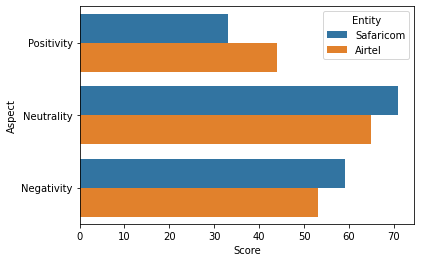

In [19]:
sns.barplot(data=brand_sentiments_df, x="Score", y="Aspect", orient="h", hue="Entity")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


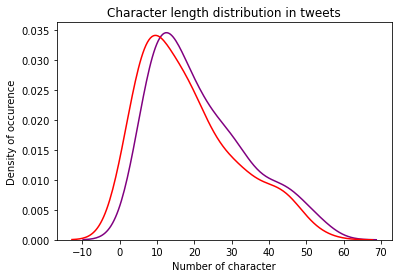

In [20]:
def get_average_chars_per_tweet(raw_tweets, cleaned_tweets):
    raw_tweet_word_count = raw_tweets.str.split().map(lambda x: len(x))
    cleaned_tweet_word_count = cleaned_tweets.str.split().map(lambda y: len(y))
    sns.distplot(raw_tweet_word_count.map(lambda x: np.mean(x)),hist=False,  color="purple", label="Raw Tweets")
    sns.distplot(cleaned_tweet_word_count.map(lambda y: np.mean(y)), hist=False, color="red", label="Cleaned Tweets")
    plt.title("Character length distribution in tweets")
    plt.xlabel("Number of character")
    plt.ylabel("Density of occurence")
    plt.show()
get_average_chars_per_tweet(airtel_saf_annotated['tweet'], airtel_saf_annotated['clean_tweets'])

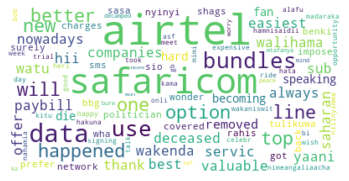

In [21]:
def word_cloud_per_sentiment(df, sentiment_label, entity_aspect):
    wc = WordCloud(#stopwords=stopwords,
               background_color="white",
               max_words=100, max_font_size=50,
               random_state=42)
    if entity_aspect == "airtel_positivity":
        wc.generate(str(df[df.iloc[:, 2]==sentiment_label]['clean_tweets']))
    elif entity_aspect == "airtel_negativity":
        wc.generate(str(df[df.iloc[:, 4] == sentiment_label]['clean_tweets']))
    elif entity_aspect == "airtel_neutrality":
        wc.generate(str(df[df.iloc[:, 3] == sentiment_label]['clean_tweets']))
    elif entity_aspect == "safaricom_positivity":
        wc.generate(str(df[df.iloc[:, 5] == sentiment_label]['clean_tweets']))
    elif entity_aspect == "safaricom_neutrality":
        wc.generate(str(df[df.iloc[:, 6] == sentiment_label]['clean_tweets']))
    elif entity_aspect == "safaricom_negativity":
        wc.generate(str(df[df.iloc[:, 7] == sentiment_label]['clean_tweets']))
        
    #wc.generate(str(df[df==sentiment]['clean_text-stopwords']))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()
word_cloud_per_sentiment(airtel_saf_annotated, 1, "airtel_positivity")

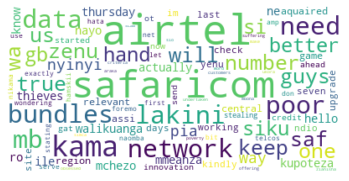

In [23]:
word_cloud_per_sentiment(airtel_saf_annotated, 1, "airtel_negativity")

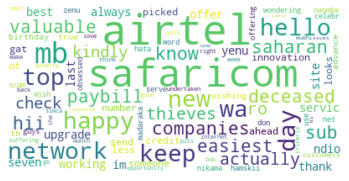

In [25]:
word_cloud_per_sentiment(airtel_saf_annotated, 1, "safaricom_positivity")

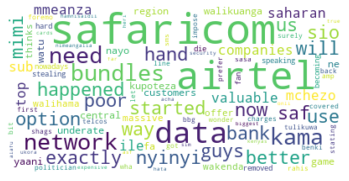

In [26]:
word_cloud_per_sentiment(airtel_saf_annotated, 1, "safaricom_negativity")

# MACHINE LEARNING MODELS

In [27]:
#MODELLING
def cv_text_vectorizer(text):
    '''
    A python function that converts input text into vectors to be fed into ML algos. 
    Here we experiment with count vectorizer .  
    CV work with n-grams when performing text vectorization. 
    Here we work with the default n-gram range for count vectorizer(1,1). 
    '''
    cv = CountVectorizer()
    cv_vectors = cv.fit_transform(text)
    return cv_vectors, cv.get_feature_names_out()
def tfidf_text_vectorizer(text):
    """
    Implementation of TFIDF vectorizer for text encoding
    """
    tfidf_vect = TfidfVectorizer(ngram_range=(2,2))
    vectors = tfidf_vect.fit_transform(text)
    return vectors, tfidf_vect.get_feature_names

In [30]:
cvVectors, feature_names = cv_text_vectorizer(airtel_saf_annotated['clean_tweets'])
tfidfVectors, tfidf_feat_names = tfidf_text_vectorizer(airtel_saf_annotated['clean_tweets'])
cvVectors, tfidfVectors# gives us the dimensions of the text vectors(number of features, vocab size)
#note that tfidf vectorizer returns double the vocab size of count vectorizer. This is critical in determining model performance

(<162x1152 sparse matrix of type '<class 'numpy.int64'>'
 	with 2603 stored elements in Compressed Sparse Row format>,
 <162x2428 sparse matrix of type '<class 'numpy.float64'>'
 	with 2663 stored elements in Compressed Sparse Row format>)

In [31]:
le = LabelEncoder()
targets = airtel_saf_annotated[['Airtel_Pos', 'Airtel_Neut', 'Airtel_Neg', 
                     'Saf_Pos', 'Saf_Neut', 'Saf_Neg']]
for col in targets.columns:
    targets[col] = le.fit_transform(targets[col])
targets.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Airtel_Pos,Airtel_Neut,Airtel_Neg,Saf_Pos,Saf_Neut,Saf_Neg
0,1,0,0,1,0,1
1,1,0,0,1,0,0


In [32]:
def split_data(features, target):
    train_feats, test_feats, y_train, y_test = train_test_split(features, target)
    return train_feats, test_feats, y_train, y_test

In [33]:
cv_train, cv_test, y_train, y_test = split_data(cvVectors, targets)
tfidf_train, tfidf_test, y_train, y_test = split_data(tfidfVectors, targets)

## Model Factory

In [34]:
def compare_models(train_feats, test_feats, train_tgt, test_tgt):
    models = list()
    models.append(("LR", OneVsRestClassifier(LogisticRegression())))
    models.append(("MNB", OneVsRestClassifier(MultinomialNB())))
    models.append(("GNB", OneVsRestClassifier(GaussianNB())))
    models.append(("SVM", OneVsRestClassifier(SVC())))
    models.append(("RF", OneVsRestClassifier(RandomForestClassifier())))
    models.append(("XGB", OneVsRestClassifier(XGBClassifier())))
    models.append(("KNN", OneVsRestClassifier(KNeighborsClassifier())))
    models.append(("D.Tree", OneVsRestClassifier(DecisionTreeClassifier())))
    models.append(("MLP", OneVsRestClassifier(MLPClassifier())))
    
    model_results = list()
    model_names = list()
    metric = "accuracy"
    for model_name, model in models:
        clf = model
        clf.fit(train_feats.toarray(), train_tgt)
        predictions = clf.predict(test_feats.toarray())
        clf_score = accuracy_score(predictions, test_tgt)
        model_results.append(clf_score)
        model_names.append(model_name)
        msg = "%s: %f" % (model_name, clf_score.mean())
        print(msg)
        print(classification_report(predictions, test_tgt))

### Count vectorizer performance

In [39]:
compare_models(cv_train, cv_test, y_train, y_test)

LR: 0.048780
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.25      0.44      0.32         9
           2       0.07      0.33      0.11         3
           3       0.00      0.00      0.00         0
           4       0.18      0.30      0.22        10
           5       0.06      0.50      0.11         2

   micro avg       0.11      0.38      0.17        24
   macro avg       0.09      0.26      0.13        24
weighted avg       0.18      0.38      0.24        24
 samples avg       0.11      0.13      0.12        24

MNB: 0.048780
              precision    recall  f1-score   support

           0       0.20      0.17      0.18        12
           1       0.25      0.31      0.28        13
           2       0.47      0.39      0.42        18
           3       0.38      0.20      0.26        15
           4       0.41      0.41      0.41        17
           5       0.19      0.38      0.25        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.06      0.50      0.11         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

   micro avg       0.01      0.50      0.02         2
   macro avg       0.01      0.08      0.02         2
weighted avg       0.06      0.50      0.11         2
 samples avg       0.01      0.02      0.02         2

RF: 0.000000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.06      0.50      0.11         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         0

   micro a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGB: 0.048780
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.19      0.30      0.23        10
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.24      0.29      0.26        14
           5       0.12      0.29      0.17         7

   micro avg       0.11      0.26      0.16        34
   macro avg       0.09      0.15      0.11        34
weighted avg       0.18      0.26      0.21        34
 samples avg       0.11      0.16      0.13        34

KNN: 0.000000
              precision    recall  f1-score   support

           0       0.30      0.27      0.29        11
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.12      0.14      0.13       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

MLP: 0.121951
              precision    recall  f1-score   support

           0       0.10      0.20      0.13         5
           1       0.19      0.38      0.25         8
           2       0.33      0.56      0.42         9
           3       0.38      0.50      0.43         6
           4       0.18      0.23      0.20        13
           5       0.12      0.40      0.19         5

   micro avg       0.21      0.37      0.27        46
   macro avg       0.22      0.38      0.27        46
weighted avg       0.22      0.37      0.27        46
 samples avg       0.21      0.27      0.23        46



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
#TFIDF VECTORIZER RESULTS
compare_models(tfidf_train, tfidf_test, y_train, y_test)

LR: 0.000000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         2
   macro avg       0.00      0.00      0.00         2
weighted avg       0.00      0.00      0.00         2
 samples avg       0.00      0.00      0.00         2

MNB: 0.000000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.12      0.50      0.19         4
           5       0.00      0.00      0.00        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

GNB: 0.195122
              precision    recall  f1-score   support

           0       0.60      0.33      0.43        18
           1       0.75      0.50      0.60        24
           2       0.67      0.43      0.53        23
           3       0.50      0.20      0.29        20
           4       0.71      0.44      0.55        27
           5       0.56      0.45      0.50        20

   micro avg       0.65      0.40      0.50       132
   macro avg       0.63      0.39      0.48       132
weighted avg       0.64      0.40      0.49       132
 samples avg       0.65      0.43      0.48       132



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM: 0.024390
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.06      0.50      0.11         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.06      0.50      0.11         2
           5       0.00      0.00      0.00         0

   micro avg       0.02      0.50      0.05         4
   macro avg       0.02      0.17      0.04         4
weighted avg       0.06      0.50      0.11         4
 samples avg       0.02      0.02      0.02         4



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF: 0.292683
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.94      0.42      0.58        36
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.41      0.59        41
           5       0.00      0.00      0.00         0

   micro avg       0.39      0.42      0.40        77
   macro avg       0.32      0.14      0.19        77
weighted avg       0.97      0.42      0.58        77
 samples avg       0.39      0.40      0.39        77



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGB: 0.000000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         4
   macro avg       0.00      0.00      0.00         4
weighted avg       0.00      0.00      0.00         4
 samples avg       0.00      0.00      0.00         4

KNN: 0.195122
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         3
           1       0.94      0.52      0.67        29
           2       0.13      1.00      0.24         2
           3       0.00      0.00      0.00         1
           4       0.47      0.62      0.53        13
           5       0.31      0.33      0.32       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


D.Tree: 0.195122
              precision    recall  f1-score   support

           0       0.10      0.33      0.15         3
           1       0.88      0.40      0.55        35
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.82      0.41      0.55        34
           5       0.06      0.50      0.11         2

   micro avg       0.37      0.38      0.37        79
   macro avg       0.31      0.27      0.23        79
weighted avg       0.75      0.38      0.49        79
 samples avg       0.37      0.39      0.37        79



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP: 0.195122
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.75      0.52      0.62        23
           2       0.13      1.00      0.24         2
           3       0.00      0.00      0.00         1
           4       0.82      0.47      0.60        30
           5       0.00      0.00      0.00         0

   micro avg       0.34      0.50      0.41        56
   macro avg       0.28      0.33      0.24        56
weighted avg       0.75      0.50      0.58        56
 samples avg       0.34      0.43      0.37        56



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
#using keras' tokenizer for encoding. 
#we extract maximum features from the EDA on char length distribution
char_length = 60
def tokenize_text(max_char_length, text):
  max_features = max_char_length
  tokenizer = Tokenizer(num_words = max_features, split = " ")
  tokenizer.fit_on_texts(text)
  X = tokenizer.texts_to_sequences(text)
  X = pad_sequences(X)
  return X, len(tokenizer.word_index)

In [42]:
airtel_saf_annotated = airtel_saf_annotated.dropna()

In [44]:
lstm_features, vocab_size = tokenize_text(60, airtel_saf_annotated['clean_tweets'])
lstm_features.shape, vocab_size

((162, 25), 1165)

In [62]:
embed_dim = 150
lstm_out = 196
lstm_model = Sequential()
lstm_model.add(Embedding(1165, embed_dim, input_length = 25)) # for airtel df, change from 10115 to 4544
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
lstm_model.add(Dense(6, activation="sigmoid"))
lstm_model.compile(loss="CategoricalCrossentropy",optimizer="adam", metrics=["accuracy"])
print(lstm_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 25, 150)           174750    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 25, 150)          0         
 alDropout1D)                                                    
                                                                 
 lstm_7 (LSTM)               (None, 196)               272048    
                                                                 
 dense_8 (Dense)             (None, 6)                 1182      
                                                                 
Total params: 447,980
Trainable params: 447,980
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
embed_dim = 150
GRU_out = 196
GRU_model = Sequential()
GRU_model.add(Embedding(1165, embed_dim, input_length = 25)) # for airtel df, change from 10115 to 4544
GRU_model.add(SpatialDropout1D(0.2))
GRU_model.add(GRU(GRU_out, dropout = 0.2, recurrent_dropout = 0.2))
GRU_model.add(Dense(6, activation="sigmoid"))
GRU_model.compile(loss="CategoricalCrossentropy",optimizer="adam", metrics=["accuracy"])
print(GRU_model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 25, 150)           174750    
                                                                 
 spatial_dropout1d_11 (Spati  (None, 25, 150)          0         
 alDropout1D)                                                    
                                                                 
 gru_4 (GRU)                 (None, 196)               204624    
                                                                 
 dense_9 (Dense)             (None, 6)                 1182      
                                                                 
Total params: 380,556
Trainable params: 380,556
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
tok_train, tok_test, y_train, y_test = train_test_split(lstm_features, targets)

In [65]:
#training
batch_size = 32
lstm_model.fit(tok_train, y_train, epochs = 20, batch_size=batch_size, verbose = 2)

Epoch 1/20
4/4 - 4s - loss: 3.5875 - accuracy: 0.0661 - 4s/epoch - 990ms/step
Epoch 2/20
4/4 - 1s - loss: 3.5349 - accuracy: 0.0000e+00 - 590ms/epoch - 148ms/step
Epoch 3/20
4/4 - 1s - loss: 4.3515 - accuracy: 0.0000e+00 - 580ms/epoch - 145ms/step
Epoch 4/20
4/4 - 1s - loss: 4.5017 - accuracy: 0.0000e+00 - 585ms/epoch - 146ms/step
Epoch 5/20
4/4 - 1s - loss: 4.2652 - accuracy: 0.0000e+00 - 570ms/epoch - 143ms/step
Epoch 6/20
4/4 - 1s - loss: 4.0404 - accuracy: 0.0000e+00 - 581ms/epoch - 145ms/step
Epoch 7/20
4/4 - 1s - loss: 3.9104 - accuracy: 0.1240 - 583ms/epoch - 146ms/step
Epoch 8/20
4/4 - 1s - loss: 3.8492 - accuracy: 0.0000e+00 - 565ms/epoch - 141ms/step
Epoch 9/20
4/4 - 1s - loss: 3.8046 - accuracy: 0.0000e+00 - 575ms/epoch - 144ms/step
Epoch 10/20
4/4 - 1s - loss: 3.7499 - accuracy: 0.0000e+00 - 584ms/epoch - 146ms/step
Epoch 11/20
4/4 - 1s - loss: 3.7422 - accuracy: 0.0992 - 572ms/epoch - 143ms/step
Epoch 12/20
4/4 - 1s - loss: 3.7252 - accuracy: 0.3554 - 573ms/epoch - 143ms/s

In [66]:
GRU_model.fit(tok_train, y_train, epochs = 20, batch_size=batch_size, verbose = 2)

Epoch 1/20
4/4 - 5s - loss: 3.5868 - accuracy: 0.1240 - 5s/epoch - 1s/step
Epoch 2/20
4/4 - 0s - loss: 3.5498 - accuracy: 0.0661 - 498ms/epoch - 124ms/step
Epoch 3/20
4/4 - 1s - loss: 3.5087 - accuracy: 0.0083 - 514ms/epoch - 128ms/step
Epoch 4/20
4/4 - 1s - loss: 4.2015 - accuracy: 0.0000e+00 - 505ms/epoch - 126ms/step
Epoch 5/20
4/4 - 1s - loss: 5.9406 - accuracy: 0.2066 - 513ms/epoch - 128ms/step
Epoch 6/20
4/4 - 1s - loss: 5.6815 - accuracy: 0.4050 - 504ms/epoch - 126ms/step
Epoch 7/20
4/4 - 1s - loss: 5.2868 - accuracy: 0.4050 - 524ms/epoch - 131ms/step
Epoch 8/20
4/4 - 1s - loss: 5.0305 - accuracy: 0.2066 - 500ms/epoch - 125ms/step
Epoch 9/20
4/4 - 1s - loss: 4.8540 - accuracy: 0.2727 - 522ms/epoch - 130ms/step
Epoch 10/20
4/4 - 1s - loss: 4.7374 - accuracy: 0.4050 - 509ms/epoch - 127ms/step
Epoch 11/20
4/4 - 1s - loss: 4.6852 - accuracy: 0.4050 - 521ms/epoch - 130ms/step
Epoch 12/20
4/4 - 1s - loss: 4.6611 - accuracy: 0.3967 - 503ms/epoch - 126ms/step
Epoch 13/20
4/4 - 1s - loss

In [67]:
#testing model performance
lstm_score,lstm_acc = lstm_model.evaluate(tok_test, y_test, verbose = 2, batch_size = batch_size)
GRU_score, GRU_acc = GRU_model.evaluate(tok_test, y_test, verbose=2, batch_size=batch_size)
#print("score: %.2f" % (score))
print("LSTM acc: %.2f" % (lstm_acc))
print("GRU acc: %.2f" % (GRU_acc))

2/2 - 2s - loss: 3.7196 - accuracy: 0.0000e+00 - 2s/epoch - 808ms/step
2/2 - 1s - loss: 4.6453 - accuracy: 0.2927 - 940ms/epoch - 470ms/step
LSTM acc: 0.00
GRU acc: 0.29


In [73]:
# create the model
cnn_model = Sequential()
cnn_model.add(Embedding(1165, embed_dim, input_length=25))
cnn_model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(6, activation='sigmoid'))
cnn_model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 25, 150)           174750    
                                                                 
 conv1d_6 (Conv1D)           (None, 25, 128)           76928     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 12, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 6, 32)           

In [74]:
# Fit the model
cnn_model.fit(tok_train, y_train, 
          validation_split=0.1,
          epochs=20, 
          batch_size=32, 
          verbose=1)

Epoch 1/20
4/4 [==============================] - 2s 102ms/step - loss: 3.5973 - accuracy: 0.0741 - val_loss: 3.5687 - val_accuracy: 0.0000e+00
Epoch 2/20
4/4 [==============================] - 0s 27ms/step - loss: 3.5758 - accuracy: 0.0000e+00 - val_loss: 3.5770 - val_accuracy: 0.0000e+00
Epoch 3/20
4/4 [==============================] - 0s 27ms/step - loss: 3.6108 - accuracy: 0.0000e+00 - val_loss: 3.9420 - val_accuracy: 0.0000e+00
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 4.0576 - accuracy: 0.0000e+00 - val_loss: 5.1688 - val_accuracy: 0.0000e+00
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 5.0765 - accuracy: 0.1296 - val_loss: 7.4530 - val_accuracy: 0.2308
Epoch 6/20
4/4 [==============================] - 0s 27ms/step - loss: 6.8722 - accuracy: 0.2963 - val_loss: 11.1671 - val_accuracy: 0.0000e+00
Epoch 7/20
4/4 [==============================] - 0s 26ms/step - loss: 10.0847 - accuracy: 0.1111 - val_loss: 17.4975 - val_accuracy

In [75]:
CNN_score, CNN_acc = cnn_model.evaluate(tok_test, y_test, verbose=2, batch_size=batch_size)
CNN_score, CNN_acc

2/2 - 0s - loss: 15178.2412 - accuracy: 0.0000e+00 - 41ms/epoch - 21ms/step


(15178.2412109375, 0.0)